### **Importy**

Poniższy kod importuje różne biblioteki i moduły niezbędne do budowy i trenowania modelu klasyfikacji raka skóry:

- `os`: Interakcja z systemem operacyjnym.
- `pandas`: Analiza danych.
- `matplotlib.pyplot`: Wizualizacja danych.
- `tensorflow`: Budowanie i trenowanie modeli neuronowych.
- `numpy`: Obliczenia numeryczne.
- `ImageDataGenerator`: Augmentacja obrazów.
- `Sequential`: Model sekwencyjny Keras.
- `Warstwy Keras`: Konwolucyjne, pooling, spłaszczanie, gęste, dropout, global average pooling.
- `MobileNetV2`: Pretrenowany model do transfer learningu.
- `Adam`: Optymalizator.
- `train_test_split`: Podział danych na zestawy treningowe i testowe.
- `kagglehub`: Interakcja z platformą Kaggle.
- `EarlyStopping`: Zatrzymanie treningu przy braku poprawy.
- `load_model`: Ładowanie zapisanych modeli.
- `confusion_matrix, ConfusionMatrixDisplay`: Macierz pomyłek i jej wizualizacja.
- `PIL`: Manipulacja obrazami.
- `compute_class_weight`: Obliczanie wag klas dla niezbalansowanych danych.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import kagglehub
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

### **Pobieranie i przygotowanie danych**

Poniższy kod pobiera i przygotowuje dane do trenowania modelu klasyfikacji raka skóry:

- Pobieranie datasetu `HAM10000` z Kaggle.
- Szukanie i wczytywanie pliku metadanych `HAM10000_metadata.csv`.
- Szukanie katalogów z obrazami.
- Dodanie ścieżek do obrazów w dataframe.
- Podział danych na zbiory treningowy, walidacyjny i testowy.
- Obliczanie wag klas dla niezbalansowanych danych.
- Tworzenie generatorów danych z augmentacją dla zbioru treningowego oraz normalizacją dla zbiorów walidacyjnego i testowego.
- Wyświetlanie rozkładu klas w zbiorach danych.

In [ ]:
print("Pobieranie datasetu HAM10000...")
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
base_path = path[0]

print("\nSzukanie pliku metadata...")
metadata_file = None
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file == 'HAM10000_metadata.csv':
            metadata_file = os.path.join(root, file)
            print(f"Znaleziono plik metadata: {metadata_file}")
            break
    if metadata_file:
        break

print("\nWczytywanie metadanych...")
df = pd.read_csv(metadata_file)

print("\nSzukanie obrazów...")
images_dirs = []
for root, dirs, files in os.walk(base_path):
    for dir_name in dirs:
        if dir_name.startswith('HAM10000_images'):
            images_dirs.append(os.path.join(root, dir_name))

print(f"Znalezione katalogi z obrazami: {images_dirs}")

def find_image_path(image_id):
    for dir_path in images_dirs:
        img_path = os.path.join(dir_path, f'{image_id}.jpg')
        if os.path.exists(img_path):
            return img_path
    return None

df['filepath'] = df['image_id'].apply(find_image_path)

df = df.dropna(subset=['filepath'])

print("\nRozkład klas w zbiorze:")
print(df['dx'].value_counts())

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

print(f"\nRozmiary zbiorów:")
print(f"Rozmiar zbioru treningowego: {len(train_df)}")
print(f"Rozmiar zbioru walidacyjnego: {len(val_df)}")
print(f"Rozmiar zbioru testowego: {len(test_df)}")

img_size = (224, 224)
batch_size = 32

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),
    y=train_df['dx']
)
class_weight_dict = dict(zip(range(len(np.unique(train_df['dx']))), class_weights))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2],
    shear_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("\nRozkład klas w zbiorach:")
print("\nZbiór treningowy:")
print(train_df['dx'].value_counts())
print("\nZbiór walidacyjny:")
print(val_df['dx'].value_counts())
print("\nZbiór testowy:")
print(test_df['dx'].value_counts())

Pobieranie datasetu HAM10000...


100%|██████████| 5.20G/5.20G [03:57<00:00, 23.5MB/s]


Extracting files...

Szukanie pliku metadata...
Znaleziono plik metadata: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv

Wczytywanie metadanych...

Szukanie obrazów...
Znalezione katalogi z obrazami: ['/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2', '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1']

Rozkład klas w zbiorze:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Rozmiary zbiorów:
Rozmiar zbioru treningowego: 6009
Rozmiar zbioru walidacyjnego: 2003
Rozmiar zbioru testowego: 2003
Found 6009 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.

Rozkład klas w zbiorach:

Zbiór treningowy:
dx
nv       4023
mel       668
bkl       

### **Wizualizacja danych**

Poniższy kod wizualizuje przykłady obrazów dla każdej klasy oraz wyświetla liczbę przypadków w każdej klasie:

- `dx_descriptions`: Słownik z opisami klas zmian skórnych.
- `examples`: Słownik z przykładowymi ścieżkami do obrazów dla każdej klasy.
- Tworzenie wykresu z przykładami obrazów dla każdej klasy.
- Wyświetlanie liczby przypadków w każdej klasie.

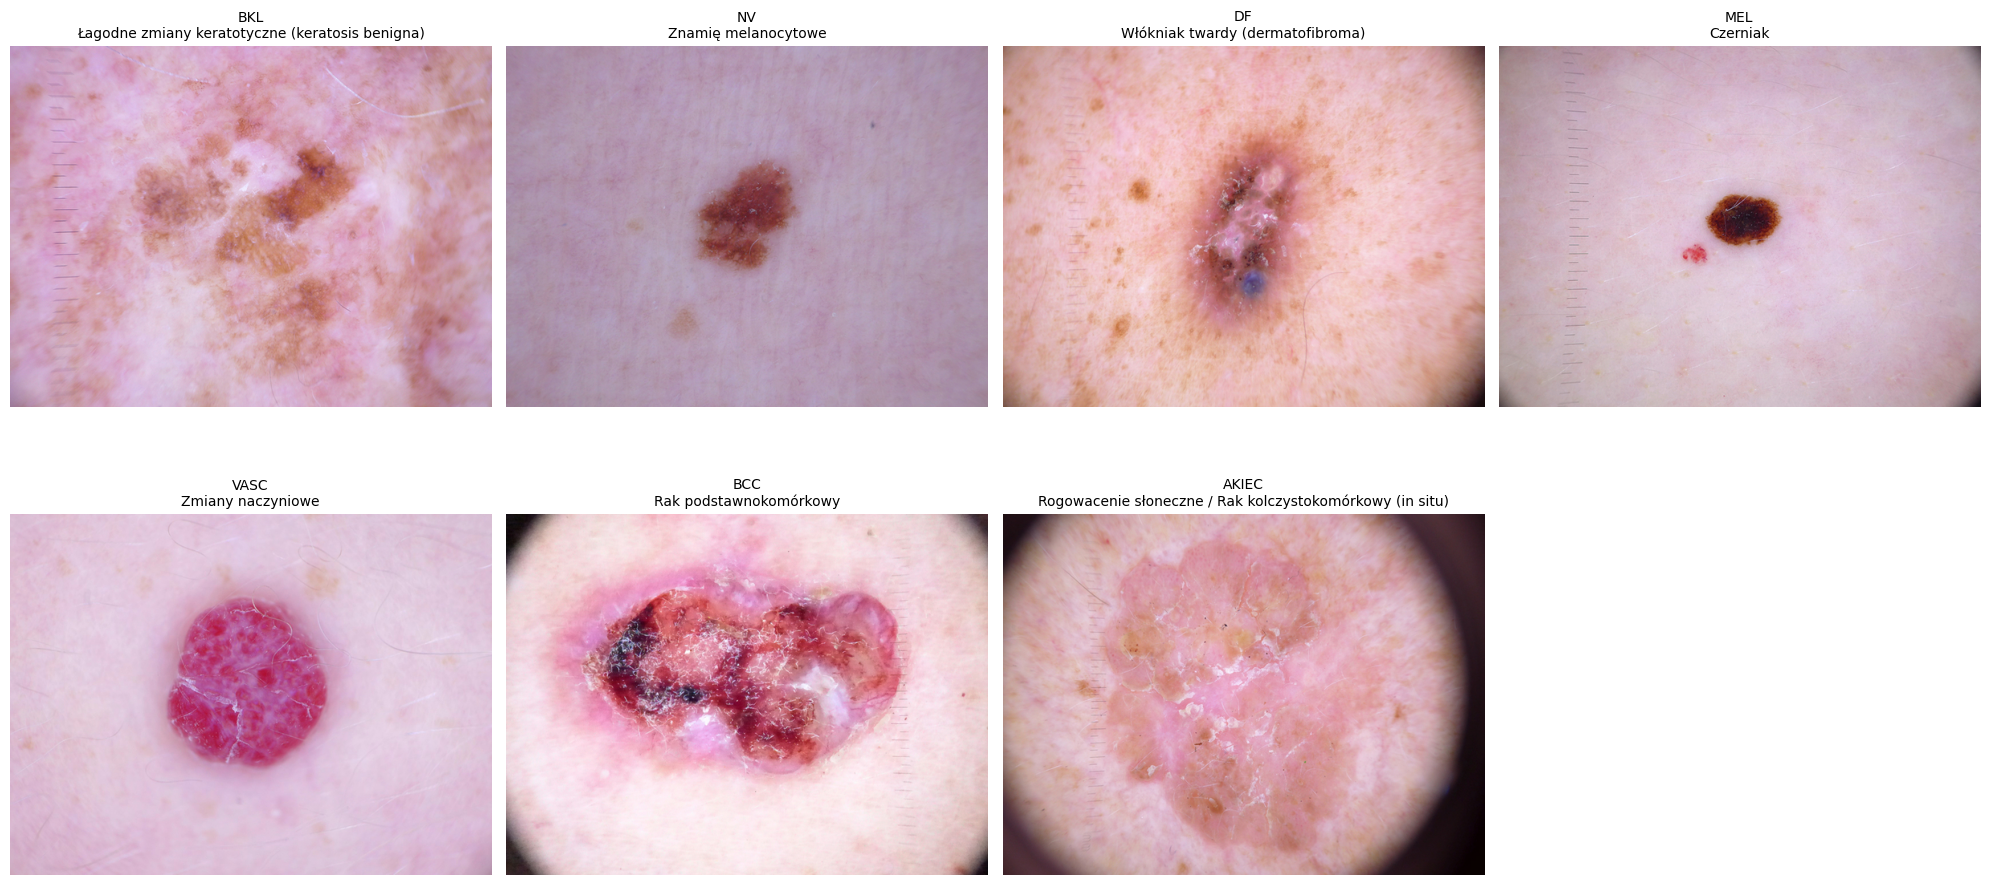


Liczba przypadków w każdej klasie:

BKL - Łagodne zmiany keratotyczne (keratosis benigna)
Liczba przypadków: 1099

NV - Znamię melanocytowe
Liczba przypadków: 6705

DF - Włókniak twardy (dermatofibroma)
Liczba przypadków: 115

MEL - Czerniak
Liczba przypadków: 1113

VASC - Zmiany naczyniowe
Liczba przypadków: 142

BCC - Rak podstawnokomórkowy
Liczba przypadków: 514

AKIEC - Rogowacenie słoneczne / Rak kolczystokomórkowy (in situ)
Liczba przypadków: 327


In [ ]:
dx_descriptions = {
    'akiec': 'Rogowacenie słoneczne / Rak kolczystokomórkowy (in situ)',
    'bcc': 'Rak podstawnokomórkowy',
    'bkl': 'Łagodne zmiany keratotyczne (keratosis benigna)',
    'df': 'Włókniak twardy (dermatofibroma)',
    'nv': 'Znamię melanocytowe',
    'mel': 'Czerniak',
    'vasc': 'Zmiany naczyniowe'
}

examples = {}
for dx in df['dx'].unique():
    example = df[df['dx'] == dx].iloc[0]
    examples[dx] = example['filepath']

plt.figure(figsize=(20, 10))

for idx, (dx, img_path) in enumerate(examples.items(), 1):
    try:
        img = Image.open(img_path)
        plt.subplot(2, 4, idx)
        plt.imshow(img)
        plt.title(f"{dx.upper()}\n{dx_descriptions[dx]}", fontsize=10)
        plt.axis('off')
    except Exception as e:
        print(f"Nie udało się załadować obrazu dla klasy {dx}: {e}")

plt.tight_layout()
plt.show()

print("\nLiczba przypadków w każdej klasie:")
class_counts = df['dx'].value_counts()
for dx in df['dx'].unique():
    print(f"\n{dx.upper()} - {dx_descriptions[dx]}")
    print(f"Liczba przypadków: {class_counts[dx]}")

### **Trenowanie modelu CNN**

Poniższy kod definiuje, kompiluje i trenuje model konwolucyjnej sieci neuronowej (CNN) od podstaw:

- Definicja modelu `Sequential` z warstwami konwolucyjnymi (`Conv2D`), pooling (`MaxPooling2D`), spłaszczającą (`Flatten`), gęstą (`Dense`) i dropout (`Dropout`).
- Kompilacja modelu z optymalizatorem `Adam`, funkcją straty `categorical_crossentropy` i metryką `accuracy`.
- Ustawienie callbacku `EarlyStopping` do zatrzymania treningu przy braku poprawy.
- Wyświetlenie podsumowania modelu.
- Trenowanie modelu na zbiorze treningowym z walidacją na zbiorze walidacyjnym, z użyciem wag klas i callbacku `EarlyStopping`.
- Zapisanie wytrenowanego modelu do pliku `model_cnn.h5`.

In [ ]:
print("Trenowanie modelu CNN od podstaw...")

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

model_cnn.summary()

history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

model_cnn.save('models/model_cnn.h5')

Trenowanie modelu CNN od podstaw...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 152s 790ms/step - accuracy: 0.2874 - loss: 2.0334 - val_accuracy: 0.5212 - val_loss: 1.4505
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 176s 662ms/step - accuracy: 0.4684 - loss: 1.9002 - val_accuracy: 0.5012 - val_loss: 1.3898
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 131s 697ms/step - accuracy: 0.4153 - loss: 1.8233 - val_accuracy: 0.4718 - val_loss: 1.3150
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 125s 664ms/step - accuracy: 0.3522 - loss: 1.8711 - val_accuracy: 0.4803 - val_loss: 1.2828
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 133s 706ms/step - accuracy: 0.4499 - loss: 1.5973 - val_accuracy: 0.5077 - val_loss: 1.2449
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 133s 711ms/step - accuracy: 0.4516 - loss: 1.5648 - val_accuracy: 0.1942 - val_loss: 1.8005
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 671ms/step - accuracy: 0.4051 - loss: 1.5203 - val_accuracy: 0.4773 - val_loss: 1.3166
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 669ms/step - accuracy: 0.4429 -

### **Wizualizacja wyników treningu**

Poniższy kod wizualizuje wyniki treningu modelu CNN:

- Tworzenie wykresu strat treningowych i walidacyjnych w zależności od epoki.
- Tworzenie wykresu dokładności treningowej i walidacyjnej w zależności od epoki.
- Wyświetlanie wykresów obok siebie dla lepszego porównania.

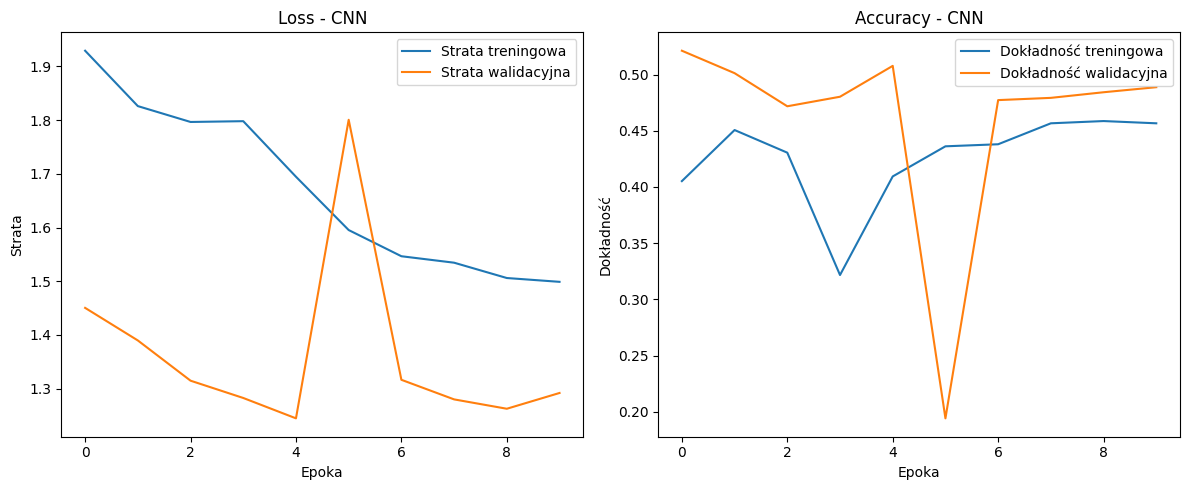

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Strata treningowa')
plt.plot(history_cnn.history['val_loss'], label='Strata walidacyjna')
plt.title('Loss - CNN')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Dokładność treningowa')
plt.plot(history_cnn.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Accuracy - CNN')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.tight_layout()
plt.show()

### **Ewaluacja modelu CNN**

Poniższy kod ocenia model CNN na zbiorze testowym:

- `y_true`: Prawdziwe klasy z generatora testowego.
- `y_pred`: Przewidywane prawdopodobieństwa klas przez model.
- `y_pred_classes`: Przewidywane klasy (indeksy) przez model.
- Obliczanie i wyświetlanie macierzy pomyłek (`confusion_matrix`).
- Wyświetlanie macierzy pomyłek jako procentów.

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step


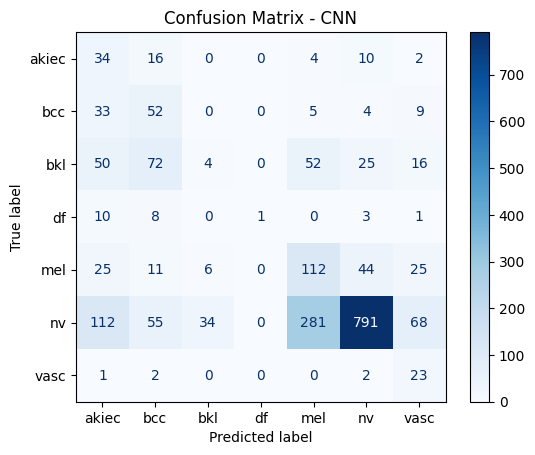

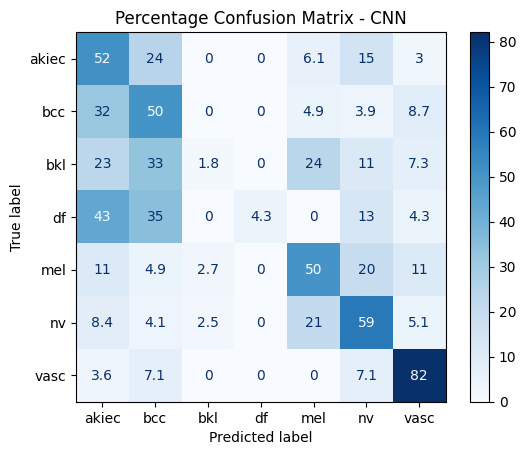

In [ ]:
y_true = test_generator.classes
y_pred = model_cnn.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices.keys())
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CNN')
plt.show()

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cmd_percentage = ConfusionMatrixDisplay(cm_percentage, display_labels=test_generator.class_indices.keys())
cmd_percentage.plot(cmap=plt.cm.Blues)
plt.title('Percentage Confusion Matrix - CNN')
plt.show()

### **Trenowanie modelu z Transfer Learningiem (MobileNetV2)**

Poniższy kod definiuje, kompiluje i trenuje model z wykorzystaniem transfer learningu na bazie MobileNetV2:

- `base_model`: Pretrenowany model MobileNetV2 bez górnych warstw, z zamrożonymi wagami.
- Definicja modelu `Sequential` z bazowym modelem, globalną warstwą pooling, gęstą warstwą i dropout.
- Kompilacja modelu z optymalizatorem `Adam`, funkcją straty `categorical_crossentropy` i metryką `accuracy`.
- Wyświetlenie podsumowania modelu.
- Trenowanie modelu na zbiorze treningowym z walidacją na zbiorze walidacyjnym, z użyciem wag klas i callbacku `EarlyStopping`.
- Zapisanie wytrenowanego modelu do pliku `model_tl.h5`.

In [ ]:
print("Trenowanie modelu z Transfer Learningiem (MobileNetV2)...")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False  

model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model_tl.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()

history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

model_tl.save('models/model_tl.h5')

Trenowanie modelu z Transfer Learningiem (MobileNetV2)...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
 40/188 ━━━━━━━━━━━━━━━━━━━━ 1:22 559ms/step - accuracy: 0.1846 - loss: 2.3188

### **Wizualizacja wyników treningu (Transfer Learning)**

Poniższy kod wizualizuje wyniki treningu modelu z transfer learningiem:

- Tworzenie wykresu strat treningowych i walidacyjnych w zależności od epoki.
- Tworzenie wykresu dokładności treningowej i walidacyjnej w zależności od epoki.
- Wyświetlanie wykresów obok siebie dla lepszego porównania.

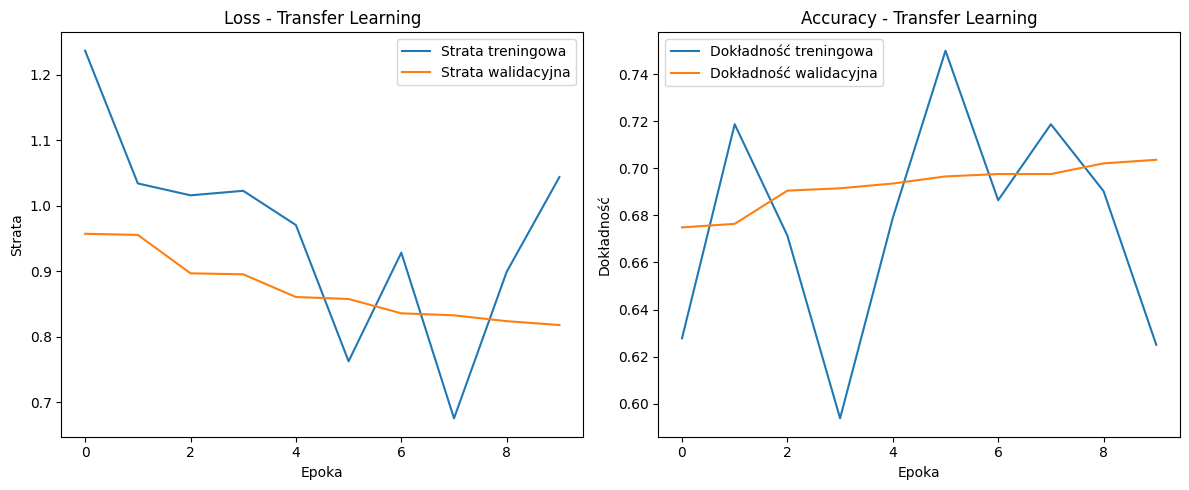

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tl.history['loss'], label='Strata treningowa')
plt.plot(history_tl.history['val_loss'], label='Strata walidacyjna')
plt.title('Loss - Transfer Learning')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tl.history['accuracy'], label='Dokładność treningowa')
plt.plot(history_tl.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Accuracy - Transfer Learning')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.tight_layout()
plt.show()

### **Ewaluacja modelu z Transfer Learningiem**

Poniższy kod ocenia model z transfer learningiem na zbiorze testowym:

- `y_true_tl`: Prawdziwe klasy z generatora testowego.
- `y_pred_tl`: Przewidywane prawdopodobieństwa klas przez model.
- `y_pred_classes_tl`: Przewidywane klasy (indeksy) przez model.
- Obliczanie i wyświetlanie macierzy pomyłek (`confusion_matrix`).
- Wyświetlanie macierzy pomyłek jako procentów.

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 279ms/step


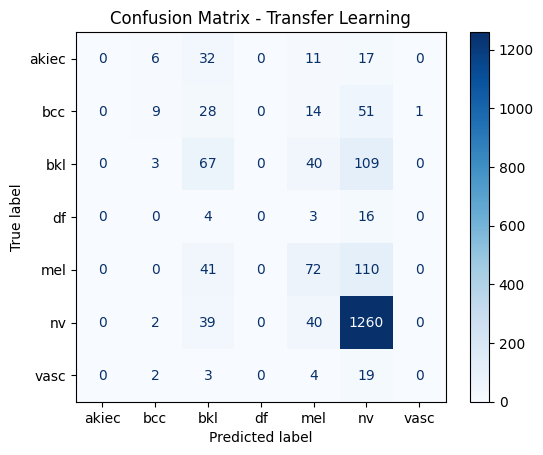

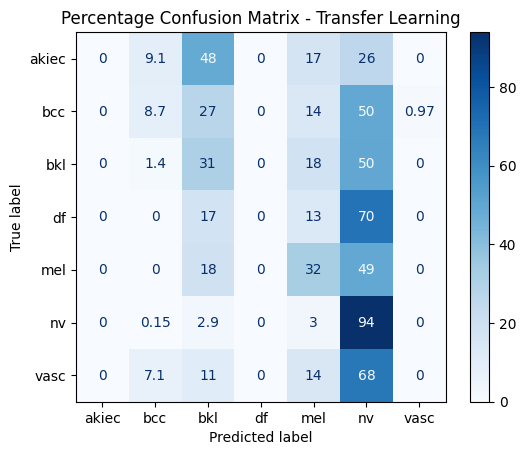

In [ ]:
y_true_tl = test_generator.classes
y_pred_tl = model_tl.predict(test_generator)
y_pred_classes_tl = np.argmax(y_pred_tl, axis=1)

cm_tl = confusion_matrix(y_true_tl, y_pred_classes_tl)
cmd_tl = ConfusionMatrixDisplay(cm_tl, display_labels=test_generator.class_indices.keys())
cmd_tl.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Transfer Learning')
plt.show()

cm_percentage_tl = cm_tl.astype('float') / cm_tl.sum(axis=1)[:, np.newaxis] * 100
cmd_percentage_tl = ConfusionMatrixDisplay(cm_percentage_tl, display_labels=test_generator.class_indices.keys())
cmd_percentage_tl.plot(cmap=plt.cm.Blues)
plt.title('Percentage Confusion Matrix - Transfer Learning')
plt.show()